In [1]:
# Load libraries
import os
import email
import pandas as pd


In [2]:
# List of all folders
all_folders=os.listdir("./SpamAssassinMessages")
# all_folders.remove(".DS_Store")
# all_folders.remove(".ipynb_checkpoints")
all_folders.sort()
all_folders

['easy_ham', 'easy_ham_2', 'hard_ham', 'spam', 'spam_2']

In [3]:
# Count emails
main_="./SpamAssassinMessages/"
count=0
for i in all_folders:
    count+=len(os.listdir(main_+i))
print("Print total emails: ",count)


Print total emails:  9353


+ interesting file ***0352.f7adb4aa267e50a8db1e4bcacfe863f3*** and file ***00341.99b463b92346291f5848137f4a253966*** are the same email

# Parse Data

In [4]:
def parse_html(text_,t):
    if "html" in t:
        soup = BeautifulSoup(text_, "html.parser")
        return(soup.get_text())
    else:
        return(text_)
    

In [5]:
from collections import Counter
from bs4 import BeautifulSoup

types=Counter()
# missed_=[]
msjs=[]
labels=[]
file_names=[]
all_list=Counter()
count=0
notMiss_=0

for root, dirs, files in os.walk("SpamAssassinMessages"):
    for f in files:
        if f != ".DS_Store":
            labels.append(int("spam" in root))
            file_names.append(os.path.join(root,f))
            
            notMiss_=0
            with open(os.path.join(root,f),'r',encoding='latin-1') as file_point:
                count+=1
                msg=email.message_from_file(file_point, )
                type_=msg.get_content_type()
                types[type_]+=1
                # Multipart/report
                if  (type(msg.get_payload())==list) and ("text" in msg.get_payload()[0].get_content_type()):
                    type_=msg.get_payload()[0].get_content_type()
                    msg=msg.get_payload()[0].get_payload()
                    msjs.append(parse_html(msg,type_))
                    notMiss_+=1
                    continue
                if type_=='multipart/signed' or type_=='multipart/mixed' or type_=='multipart/related':
                    # first file is Multi/mixm and within the first file is txt
                    if (msg.get_payload()[0].get_content_type()=="multipart/mixed") or (msg.get_payload()[0].get_content_type()=="multipart/alternative"):
                        type_=msg.get_payload()[0].get_payload()[0].get_content_type()
                        msg=msg.get_payload()[0].get_payload()[0].get_payload()
                        msjs.append(parse_html(msg,type_))
                        notMiss_+=1
                        continue
                if "text" in type_ or type(msg.get_payload())==str:
                    msg=msg.get_payload()
                    msjs.append(parse_html(msg,type_))
                    notMiss_+=1
                if notMiss_==0:
                    all_list[type_]+=1
                    msjs.append(msg)
                    print(file_point)

print(types)


Counter({'text/plain': 7413, 'text/html': 1193, 'multipart/alternative': 326, 'multipart/signed': 180, 'multipart/mixed': 179, 'multipart/related': 56, 'multipart/report': 5, 'text/plain charset=us-ascii': 1})


In [6]:
#Check q
print("Total Emails retrieved: ", len(msjs),'\n Total Emails:',count)


Total Emails retrieved:  9353 
 Total Emails: 9353


In [7]:
#Captures all missed emails
all_list


Counter()

+ Create Data Frame

In [8]:
data=pd.DataFrame({'MessageFile':file_names,"Target":labels, "Emails":msjs})
data.head()

,MessageFile,Target,Emails
0,SpamAssassinMessages\easy_ham\00001.7c53336b37...,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
1,SpamAssassinMessages\easy_ham\00002.9c4069e25e...,0,"Martin A posted:\nTassos Papadopoulos, the Gre..."
2,SpamAssassinMessages\easy_ham\00003.860e3c3cee...,0,Man Threatens Explosion In Moscow \n\nThursday...
3,SpamAssassinMessages\easy_ham\00004.864220c5b6...,0,Klez: The Virus That Won't Die\n \nAlready the...
4,SpamAssassinMessages\easy_ham\00005.bf27cdeaf0...,0,"> in adding cream to spaghetti carbonara, whi..."


# Cleaning the data

In [9]:
# # English stop words
# nlp = spacy.load('en_core_web_sm')
# stop_words = nlp.Defaults.stop_words

In [10]:
# Clean up text
import nltk
import numpy as np
import contractions
import re

#Lemmatization - stemming based on POS

stop_words= nltk.corpus.stopwords.words('english')
def normalize_document(doc):
    """Function from our class python files to normalize text""" 
    # Expand contractions
    doc=contractions.fix(doc.lower()) 
    # Remove HTLM section
    doc = re.sub(r'https?://\S+|www\.\S+', " ", doc, re.I|re.A)
    # remove special characters\whitespaces
    doc = re.sub(r'[^a-z]', ' ', doc)
#     doc = re.sub(r'[^a-zA-Z]', ' ', doc, re.I|re.A)
    # Remove tags \n \t
    re.sub(r'<[^>]*>|[\n\t]', ' ', doc)
#     doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

#Normalize text
cleanedEmails = normalize_corpus(data["Emails"])


In [11]:
data["Emails"]=cleanedEmails


In [12]:
data.head()


,MessageFile,Target,Emails
0,SpamAssassinMessages\easy_ham\00001.7c53336b37...,0,date wed aug chris garrigues cwg dated fa deep...
1,SpamAssassinMessages\easy_ham\00002.9c4069e25e...,0,martin posted tassos papadopoulos greek sculpt...
2,SpamAssassinMessages\easy_ham\00003.860e3c3cee...,0,man threatens explosion moscow thursday august...
3,SpamAssassinMessages\easy_ham\00004.864220c5b6...,0,klez virus die already prolific virus ever kle...
4,SpamAssassinMessages\easy_ham\00005.bf27cdeaf0...,0,adding cream spaghetti carbonara effect pasta ...


In [13]:
# Testing WWW. reg
# re.sub(r'https?://\S+|www\.\S+', " ", data["Emails"][30], re.I|re.A)
data["Emails"][30]

'joseph barrera iii wrote chris haun wrote lifegem certified high quality diamond created carbon loved one memorial unique wonderful life wait dead sure enough carbon fat typical liposuction job make decent diamond joe oh hell excrement would love able say sun shine ass occasional diamond owen'

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(data["Emails"])
# Convert the matrix to a Pandas DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())



In [15]:
# Compara size
dense_array = tfidf_matrix.toarray()

# Check the shapes
print("Original data shape:", np.array(data).shape)
print("Dense array shape:", dense_array.shape)

Original data shape: (9353, 3)
Dense array shape: (9353, 79992)


In [16]:
from nltk.corpus import words

# Create a set of English words
english_words = set(words.words())

# Columns
word_list = df_tfidf.columns

# Filter non-English words
english_word_list = [word for word in word_list if word.lower() in english_words]

print(english_word_list)

df_tfidf=df_tfidf[english_word_list]
df_tfidf.shape

['aa', 'aardvark', 'aba', 'abac', 'abandon', 'abandoned', 'abandonment', 'abatement', 'abb', 'abbas', 'abbey', 'abbreviation', 'abdominal', 'abduction', 'abed', 'aberrant', 'aberration', 'abhorrent', 'abide', 'ability', 'abject', 'able', 'ably', 'abnegate', 'abnormal', 'abnormality', 'abnormally', 'aboard', 'abode', 'abolish', 'abolition', 'aboriginal', 'abort', 'aborted', 'abortion', 'abortive', 'abound', 'abreast', 'abridged', 'abroad', 'abruptly', 'absconded', 'absence', 'absent', 'absinthe', 'absinthium', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorber', 'absorbing', 'absorption', 'absquatulate', 'abstract', 'abstracted', 'abstraction', 'absurd', 'absurdity', 'absurdly', 'abu', 'abundance', 'abundant', 'abundantly', 'abusable', 'abuse', 'abusive', 'abysmal', 'abyss', 'academic', 'academical', 'academy', 'acca', 'accelerate', 'accelerated', 'acceleration', 'accelerator', 'accent', 'accentuate', 'accept', 'acceptability', 'acceptable', 'acceptance', 'accepted', 'access', 'a

(9353, 16526)

In [17]:
len(df_tfidf.columns)

16526

# Run cluster

+ We tried different parameters for DBSCAN and it did not do as good job at all unlike Agglomerative Clustering

In [18]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=2).fit(df_tfidf)
clustering.labels_
clustering

DBSCAN(eps=3, min_samples=2)

In [19]:
Counter(clustering.labels_)

Counter({0: 9353})

In [20]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering().fit(df_tfidf)
clustering
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [21]:
Counter(clustering.labels_)

Counter({0: 9043, 1: 310})

In [22]:
df_tfidf["ClusterLabels"]=clustering.labels_

# Classify

In [23]:
import numpy as np
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [24]:
import seaborn as sns
target_dt=data["Target"].value_counts(normalize=True)

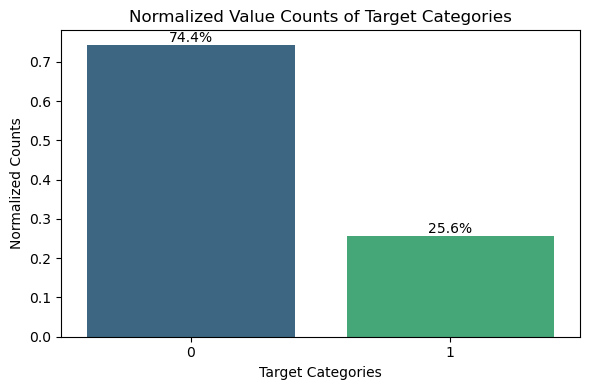

In [25]:
import matplotlib.pyplot as plt
# Create a bar plot using Seaborn
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=target_dt.index, y=target_dt.values, palette="viridis")
plt.xlabel("Target Categories")
plt.ylabel("Normalized Counts")
plt.title("Normalized Value Counts of Target Categories")

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Naive Bayes

In [27]:
# Simple Categorical NB
X_train, X_test, y_train, y_test = train_test_split(df_tfidf, data["Target"], test_size=0.3, shuffle=True, stratify=data["Target"])

In [64]:
from sklearn import metrics as mt 

# Function to get the metrics
# Spam positive class
def score_rep(model, svm="No", threshold=0.25):
    if svm=="Yes":
        preds=svm_c.decision_function(X_test)>threshold
        prob_df=pd.DataFrame({"prediProb":svm_c.decision_function(X_test), "pred": preds, "actual":y_test})
    else:
        preds = np.where(model.predict_proba(X_test)[:, 1] > threshold, 1, 0)
        prob_df = pd.DataFrame({"prediProb": model.predict_proba(X_test)[:, 1], "pred": preds, "actual": y_test})
    fp = prob_df[(prob_df["actual"] == 0) & (prob_df["pred"] == 1)].shape[0]
    tp = prob_df[(prob_df["actual"] == 1) & (prob_df["pred"] == 1)].shape[0]
    fn = prob_df[(prob_df["actual"] == 1) & (prob_df["pred"] == 0)].shape[0]
    tn = prob_df[(prob_df["actual"] == 0) & (prob_df["pred"] == 0)].shape[0]

    prec = round((tp / (fp + tp)), 3)
    rec = round((tp / (tp + fn)), 3)
    acc = round(((tp + tn) / (tp + fp + fn + tn)), 3)
    f1 = round((mt.f1_score(y_test, preds)), 3)
    auc = round((mt.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])), 3)

    print('Accuracy is: %.2f, \n Recall is: %.2f, \n Precision is: %.2f, \n F1 is %.2f and \n AUC is %.2f' % (acc, rec, prec, f1, auc))
    return preds, acc, rec, prec, f1, auc


### Categorical NB Does not work because we don't have categorical features
+ CategoricalNB is designed for data with categorical features, where each feature represents a category or label. Text data represented using TF-IDF is not categorical; it is a form of continuous data where each feature represents the importance of a word or term within a document.

In [28]:
# # Categorical NB
# clf = CategoricalNB()
# clf.fit(X_train, y_train)
# pred=clf.predict(X_test)

# acc, rec,prec,f1,auc=score_rep(clf,pred)
# model_results.append(["CategoricalNB",acc, rec,prec,f1,auc])   


### Bernoulli Naive Bayes is not a good model for our data
+ Bernoulli Naive Bayes (BernoulliNB)

Use Case: Appropriate for binary data where features are binary (0 or 1), representing the presence or absence of attributes.
Data Type: Binary or Boolean data, often used in text classification where features represent the presence or absence of words.
Assumption: Assumes that features are generated from a Bernoulli distribution.

In [29]:
# from sklearn.naive_bayes import BernoulliNB
# bernCF = BernoulliNB()

# bernCF.fit(X_train, y_train)
# pred=bernCF.predict(X_test)

# acc, rec,prec,f1,auc=score_rep(bernCF,pred)
# model_results.append(["Bernouli Naive Bayes ",acc, rec,prec,f1,auc])


### The model that works for the data and shows better results
+ Multinomial Naive Bayes (MultinomialNB)

Use Case: Typically used for discrete data, such as text data represented as counts or frequencies (e.g., bag-of-words, TF-IDF).
Data Type: Data with counts or frequencies of discrete items (e.g., word counts).
Assumption: Assumes that features are generated from a multinomial distribution

Probability Estimation: MultinomialNB estimates the conditional probability of a particular feature (term) given a class (category or label). It does this for each term and each class in the training data. The probability estimation is done using the following formula:

P(x_i | y) = (N_i + alpha) / (N_y + alpha * N_features)

P(x_i | y) is the conditional probability of feature x_i given class y.
N_i is the number of times feature x_i appears in class y.
N_y is the total count of features in class y.
N_features is the total number of features.
alpha is a smoothing parameter (Laplace smoothing or additive smoothing) to handle the issue of zero probabilities.

Class Probability: To classify a new sample, MultinomialNB calculates the probability of the sample belonging to each class based on the conditional probabilities estimated in step 2. It uses Bayes' theorem to calculate the class probability:

P(y | x) ∝ P(y) * ∏[P(x_i | y)]

P(y | x) is the probability of class y given the sample x.
P(y) is the prior probability of class y (estimated from the training data).
P(x_i | y) is the conditional probability of feature x_i given class y.
Classification: Finally, MultinomialNB assigns the class label that maximizes the posterior probability P(y | x). In other words, it selects the class with the highest estimated probability.

Key Points:

MultinomialNB assumes that features are generated from a multinomial distribution, which is suitable for count or frequency data.
Laplace smoothing (or additive smoothing) is used to avoid zero probabilities, especially when dealing with rare events.
It's a simple and efficient algorithm, making it suitable for large text datasets.
MultinomialNB is a "naive" algorithm because it assumes that features are conditionally independent given the class, which is a simplifying assumption that may not hold in all cases.
Overall, MultinomialNB is a powerful and widely used algorithm for text classification tasks, and it often provides good results, especially when working with text data and feature representations like TF-IDF.







In [56]:
from sklearn.naive_bayes import MultinomialNB
mn_NB = MultinomialNB()

mn_NB.fit(X_train, y_train)
# pred=mn_NB.predict(X_test)

pred, acc, rec,prec,f1,auc=score_rep(mn_NB)
model_results=[["Multinomial Naive Bayes ",acc, rec,prec,f1,auc]]


Accuracy is: 0.97, 
 Recall is: 0.93, 
 Precision is: 0.96, 
 F1 is 0.95 and 
 AUC is 0.99


Text(0.5, 1.0, 'Multinomial NB Confusion Matrix')

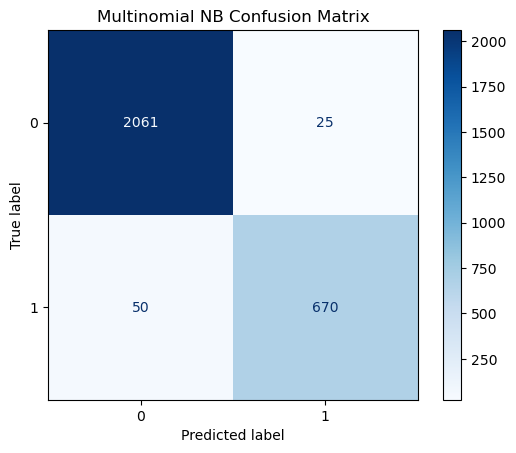

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,pred, cmap='Blues')
plt.title('Multinomial NB Confusion Matrix')

In [58]:
class_report = classification_report(y_test, pred)

print(f'Classification Report:\n{class_report}')


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2086
           1       0.96      0.93      0.95       720

    accuracy                           0.97      2806
   macro avg       0.97      0.96      0.96      2806
weighted avg       0.97      0.97      0.97      2806



##  SVM

In [65]:
from sklearn import svm
svm_c = svm.SVC(probability=True)
svm_c.fit(X_train, y_train)
# pred=svm_c.predict(X_test)


pred,acc, rec,prec,f1,auc=score_rep(svm_c,svm="Yes")
model_results.append(["SVM Classifier ",acc, rec,prec,f1,auc])

Accuracy is: 0.97, 
 Recall is: 0.91, 
 Precision is: 0.99, 
 F1 is 0.95 and 
 AUC is 1.00


In [66]:
class_report = classification_report(y_test, pred)

print(f'Classification Report:\n{class_report}')


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2086
           1       1.00      0.91      0.95       720

    accuracy                           0.97      2806
   macro avg       0.98      0.95      0.97      2806
weighted avg       0.98      0.97      0.97      2806



In [67]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold


classifier = svm.SVC(probability=True)

threshold = 0.25
sk_folds = StratifiedKFold(n_splits = 10)

# Use cross_val_predict to get predicted probabilities
predicted_probabilities = cross_val_predict(classifier,df_tfidf , data["Target"], cv=sk_folds, method='predict_proba')

# Apply the threshold to get binary predictions
predicted_labels = (predicted_probabilities[:, 1] > threshold).astype(int)

# Evaluate the model's performance with custom threshold
precision = precision_score(data["Target"], predicted_labels)
recall = recall_score(data["Target"], predicted_labels)
f1 = f1_score(data["Target"], predicted_labels)
accuracy = accuracy_score(data["Target"], predicted_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')


Precision: 0.89
Recall: 0.98
F1 Score: 0.94
Accuracy: 0.97


In [68]:

classifier = MultinomialNB()

threshold = 0.25
sk_folds = StratifiedKFold(n_splits = 10)

# Use cross_val_predict to get predicted probabilities
predicted_probabilities = cross_val_predict(classifier,df_tfidf , data["Target"], cv=sk_folds, method='predict_proba')

# Apply the threshold to get binary predictions
predicted_labels = (predicted_probabilities[:, 1] > threshold).astype(int)

# Evaluate the model's performance with custom threshold
precision = precision_score(data["Target"], predicted_labels)
recall = recall_score(data["Target"], predicted_labels)
f1 = f1_score(data["Target"], predicted_labels)
accuracy = accuracy_score(data["Target"], predicted_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')


Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Accuracy: 0.96


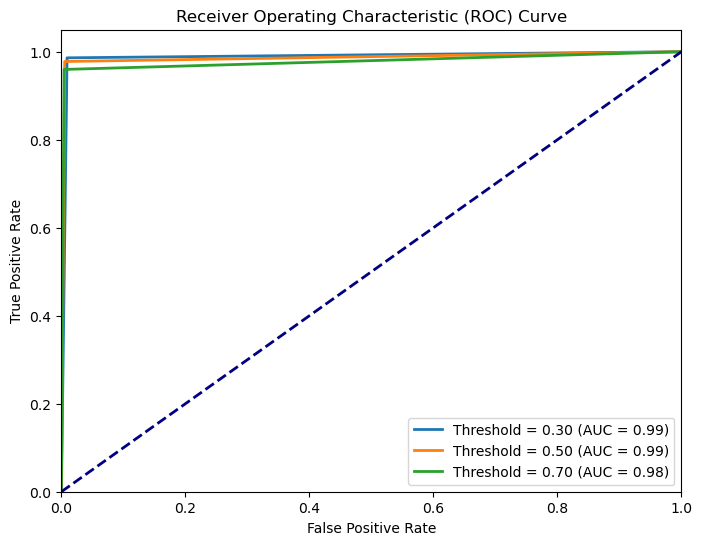

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class (class 1)
y_prob = svm_c.predict_proba(X_test)[:, 1]

# Get different threshold values to plot ROC curves
thresholds = [0.3, 0.5, 0.7]  # Adjust these values as needed

plt.figure(figsize=(8, 6))

for threshold in thresholds:
    y_pred_adjusted = (y_prob > threshold).astype(int)
    fpr, tpr, _ = roc_curve(y_test, y_pred_adjusted)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'Threshold = {threshold:.2f} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


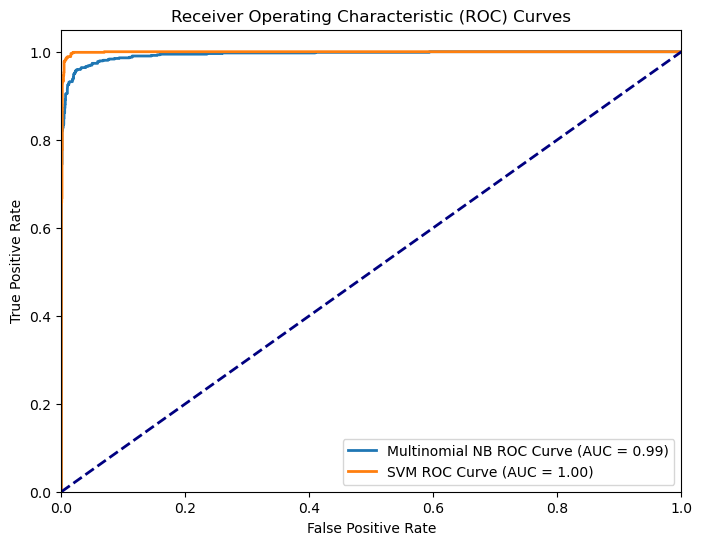

In [70]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class (class 1) for both classifiers
y_prob_nb = mn_NB.predict_proba(X_test)[:, 1]
y_prob_svm = svm_c.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC for both classifiers
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))

# Plot ROC curves for both classifiers
plt.plot(fpr_nb, tpr_nb, lw=2, label=f'Multinomial NB ROC Curve (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM ROC Curve (AUC = {roc_auc_svm:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


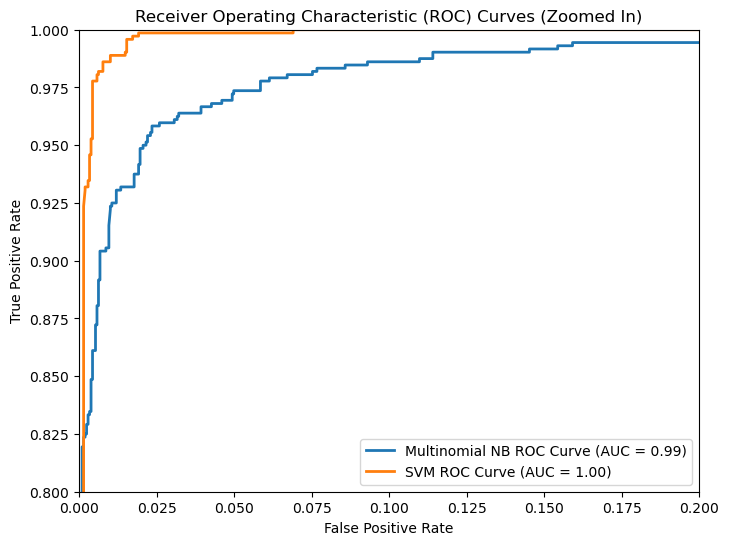

In [71]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class (class 1) for both classifiers
y_prob_nb = mn_NB.predict_proba(X_test)[:, 1]
y_prob_svm = svm_c.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC for both classifiers
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))

# Plot ROC curves for both classifiers
plt.plot(fpr_nb, tpr_nb, lw=2, label=f'Multinomial NB ROC Curve (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM ROC Curve (AUC = {roc_auc_svm:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Adjust the limits to zoom in on the top-left corner
plt.xlim([0.0, 0.2])  # Adjust these values as needed
plt.ylim([0.8, 1.0])  # Adjust these values as needed

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves (Zoomed In)')
plt.legend(loc='lower right')
plt.show()


In [72]:
from sklearn.model_selection import cross_validate

classifier = MultinomialNB()

# Running stratified kfold  cross validation with a threshold of 0.5
scoring = ['accuracy', 'precision_macro', 'recall_macro']
sk_folds = StratifiedKFold(n_splits = 10)
scores = cross_validate(classifier,df_tfidf , data["Target"], scoring=scoring, cv = sk_folds)

print("Average recall CV Score: ", np.mean(scores['test_recall_macro']))
print("Average precision CV Score: ", np.mean(scores['test_precision_macro']))
print("Average accuracy CV Score: ", np.mean(scores['test_accuracy']))

Average recall CV Score:  0.8442529103250369
Average precision CV Score:  0.9465530283832461
Average accuracy CV Score:  0.9186325928972987


In [73]:
##### Vectorize the text with TFIDF vectorizer Biagram
# from sklearn.feature_extraction.text import TfidfVectorizer

# tf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
# tfidf_matrix = tf.fit_transform(norm_corpus)
# tfidf_matrix.shape

In [74]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

scoring = ['precision_macro', 'recall_macro']
sk_folds = StratifiedKFold(n_splits = 10)


clf = CategoricalNB()
cl1 = cross_validate(clf, df_tfidf, data["Target"],  scoring=scoring, cv = sk_folds)

print(np.mean(cl1['test_recall_macro']))
print(np.mean(cl1['test_precision_macro']))
    

C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

0.5004166666666666
0.47183189359659955


C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
